# <font color='blue'><center>Forecasting stock price using Artificial Neural Network and Genetic Algorithm</center></font>

## Capstone Project

**Objective** - Forecasting stock prices is crucial in investment decision-making. Traditional statistics and artificial intelligence techniques are widely used to study price prediction. Stock prices exhibit non-linear dynamics, making it difficult to forecast through a single model. Therefore, there is a need to develop hybrid models to make more informed decisions. The main objective of this study is to forecast stock prices using Artificial Neural Network (ANN) combined with heuristic methods such as Genetic Algorithm (GA). We used technical indicators as neural network input features. In this research, the statistical population comprises three US market indices S&P500, DOW30, and NASDAQ100 for forecasting. Model performance is evaluated using Mean Absolute Percentage Error (MAPE) loss function.

**Data Source:** https://finance.yahoo.com/

In [1]:
# import the required libraries

import re
import os
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt

import yfinance as yf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf

import pygad
import pygad.nn
import pygad.gann

In [2]:
# Index symbols
#Dow Jones Industrial Average - DJI
#S&P 500 - GSPC
#NASDAQ Composite - IXIC

sdate = "2015-01-01"
edate = "2023-12-31"
symbols = ['^DJI','^GSPC','^IXIC']

# Download data from yahoo finance
dfs = []
for symbol in symbols:
    yfdata = yf.download(symbol, start=sdate, end=edate)
    yfdata['Index'] = symbol
    dfs.append(yfdata)

# Concatenate the individual DataFrames into one
idx_data = pd.concat(dfs)
idx_data.head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Index
Date,,,,,,,
2015-01-02,17823.070312,17951.779297,17731.300781,17832.990234,17832.990234,76270000,^DJI
2015-01-05,17821.300781,17821.300781,17475.929688,17501.650391,17501.650391,116160000,^DJI
2015-01-06,17504.179688,17581.050781,17262.369141,17371.640625,17371.640625,101870000,^DJI
2015-01-07,17374.779297,17597.080078,17374.779297,17584.519531,17584.519531,91030000,^DJI
2015-01-08,17591.970703,17916.039062,17591.970703,17907.869141,17907.869141,114890000,^DJI


In [3]:
#clean the Index name in the Index column
idx_data['Index'] = idx_data['Index'].apply(lambda x: re.sub("\^","",x) )
idx_data['Index'].value_counts()

Index
DJI     2264
GSPC    2264
IXIC    2264
Name: count, dtype: int64

### Check for data completeness i.e. zero datapoints or NA datapoints

In [4]:
(idx_data == 0).sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Index        0
dtype: int64

Check for NA or Null datapoints

In [5]:
idx_data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Index        0
dtype: int64

In [6]:
# size
row = idx_data.shape[0]
print(row)

6792


**Observations** - There are no invalid datapoints in our dataset. We have checked for if any datapoint is 0 or Null. Now, we plot the Closing price timeseries for each index.

In [7]:
symbols1 = [re.sub("\^","", x ) for x in symbols]
symbols1

['DJI', 'GSPC', 'IXIC']

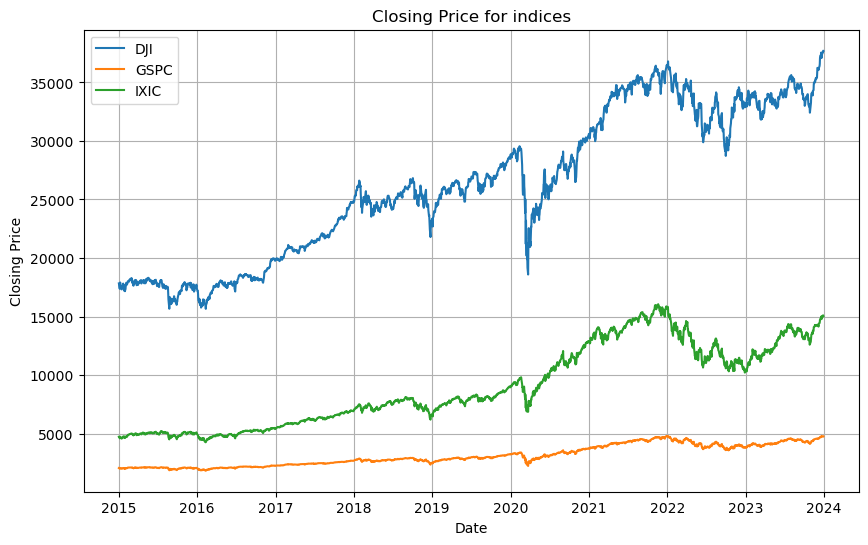

In [8]:
# Plot the closing price for each index
plt.figure(figsize=(10, 6))
for symbol in symbols1:
    ticker_data = idx_data[idx_data['Index'] == symbol]
    plt.plot(ticker_data.index, ticker_data['Close'], label=symbol)

plt.title('Closing Price for indices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()

**Observation** - From the above figure, it can be observed that stock prices are highly non-linear in nature. Hence, they cannot be easily forecasted by any time-series based or simple linear regression models. We need more dynamic and complex model that can identify the hidden patterns in the dataset and better fit the non-linearity. For this study, we are analysing artificial neural networks (ANN) model to fit this dataset. Since, hybrid model performs better in modelling non-linear and complex relations. In addition, we will also use Genetic Algorithm (GA) model to improve the performance of simple ANN model.

### Derive technical indicators

Technical analysis is a tool to forecast direction of security prices through past prices and volume data. Technical analysts say that the market price reflects all information. So, they look at security’s historical trading pattern and forecast the direction rather than company fundamentals and news events. Security prices move in trends i.e. either price can go up, down or move sideways. Technical analyst believes that history tend to repeat itself and past trading patterns might appear again. 

There are various technical indicators developed to identify Trend, Momentum, Volume, Volatility and other combinations. In this study, we have chosen most important and commonly used technical indicators among traders and portfolio managers. The technical indicators are presented in the below table.



    1.	Open	          The open price
    2.	Low               The lowest price
    3.	High	          The highest price
    4.	Close             The closing price
    5.	Volume            Number of shares traded
    6.	SMA-5             5-days simple moving average
    7.	SMA-10	        10-days simple moving average
    8.	EMA-5             5-days exponential moving average
    9.	MP	            Mean Price
    10.   TP	            Typical Price
    11.   RSI               Relative Strength Index
    12.   Williams %R       Williams Percent Range
    13.   Upper Band	    Upper Bolinger Band
    14.   Lower Band	    Lower Bolinger Band
    15.   ROC	           Rate of Change
    16.   ATR	           Average True Range	
    17.   ADL	           Accumulation distribution Line
    18.   MFI	           Money Flow Index
    19.   CCI	           Commodity Channel Index

In [9]:
# Compute technical indicators

# calculate simple moving avergae
# Input - Close prices, Window: lookback period
# Output - Returns Simple moving average
def SMA(data, window):
    cname = 'SMA_' + str(window)
    data[cname] = data.groupby('Index')['Close'].rolling(window).mean().reset_index(0, drop=True)
    return data

# calculate exponential moving avergae
# Input - Close prices, Window: lookback period
# Output - Returns exponential moving average
def EMA(data, window):
    def cal_EMA(closepx, window):
        k = 2 / (window+1)
        nrow = closepx.size
        ema = [np.nan] * nrow
        ema[window - 1] = np.mean(closepx[:window])
        for i in range(window, nrow):
            ema[i] = (closepx.iloc[i] * k) + (ema[i - 1] * (1 - k))
        return ema
    cname = 'EMA_' + str(window)
    data[cname] = data.groupby('Index')['Close'].transform(lambda x: cal_EMA(x,window))
    return data

# calculate the Bollinger Bands
# Input - Close prices, Window: lookback period
# Output - Returns Bollinger Bands using Meand and SD
def Bollinger_bands(data, window):
    data["MA"] = data.groupby('Index')['Close'].rolling(window).mean().reset_index(0, drop=True)
    data["SD"] = data.groupby('Index')['Close'].rolling(window).std().reset_index(0, drop=True)
    data['UpperBand'] = data["MA"] + (2 * data["SD"] ) 
    data['LowerBand'] = data["MA"] - (2 * data["SD"] )
    data = data.drop(['MA', 'SD'], axis=1)
    return data

# calculate rate of change
# Input - Close prices, Window: lookback period
# Output - Returns the rate of change in closing price
def ROC(data, window):
    def cal_ROC(closepx, window):
        roc = closepx.pct_change(periods=window)
        return roc
    data['ROC'] = data.groupby('Index')['Close'].transform(lambda x: cal_ROC(x,window))
    return data

# calculate RSI values
# Input - Close prices, Window: lookback period
# Output - Relative strength indicator: measures the speed and change of price movements.
def RSI(data, window):
    def cal_RSI(closepx,window):
        diff = closepx.diff(1)
        up_direction = diff.where(diff > 0, 0.0)
        down_direction = -diff.where(diff < 0, 0.0)
        min_periods = window
        emaup = up_direction.ewm(
            alpha=1 / window, min_periods=min_periods, adjust=False
        ).mean()
        emadn = down_direction.ewm(
            alpha=1 / window, min_periods=min_periods, adjust=False
        ).mean()
        relative_strength = emaup / emadn
        rsi = pd.Series(
            np.where(emadn == 0, 100, 100 - (100 / (1 + relative_strength))),
            index=closepx.index,
        )
        return rsi
    data['RSI'] = data.groupby('Index')['Close'].transform(lambda x: cal_RSI(x,window))
    return data


#Below indicators used more than one parameter in addition to Close. They also use High and Low prices.
# Volume based indicator also use Volume as their input

# Input - High, Low, Close prices, Window: lookback period
# Output - Williams %R reflects the level of the close relative to the highest high for the look-back period.
def williamsR(df,window):
    high = df["High"]
    low = df["Low"]
    close = df["Close"]
    highest_high = high.rolling( window).max()  # highest high over the window
    lowest_low =  low.rolling(window  ).min()  # lowest low over the window
    wr = -100 * (highest_high - close) / (highest_high - lowest_low)
    return wr

# Input - High, Low, Close prices, Window: lookback period
# Output - ATR measures volatility, taking into account any gaps in the price movement.
def ATR(df, window):
    high =   df['High']
    low =    df['Low']
    close =  df['Close']
    pclose = df['Close'].shift(1)
    tr1 =    high - low
    tr2 = (high - pclose).abs()
    tr3 = (low - pclose).abs()
    true_range = pd.DataFrame(data={"tr1": tr1, "tr2": tr2, "tr3": tr3}).max(axis=1)
    atr = np.full(len(close), np.nan)
    atr[window - 1] = true_range[0 : window].mean()
    for i in range(window, len(atr)):
        atr[i] = (atr[i - 1] * (window - 1) + true_range.iloc[i]) / float( window )
    #atr = pd.Series(data=atr)
    return atr

# Input - High, Low, Close prices, Volume. Window: lookback period
# Output - ADI identify divergences between the stock price and the volume flow.
def ADI(df):
    high =   df['High']
    low =    df['Low']
    close =  df['Close']
    volume = df['Volume']
    clv = ((close - low) - (high - close)) / ( high - low)
    clv = clv.fillna(0.0)  # float division by zero
    adi = clv * volume
    adi = adi.cumsum()
    return adi

# Input - High, Low, Close prices, Volume. Window: lookback period
# Output - MFI tells traders if there is a higher buying or selling pressure in the market
def MFI(df,window):
    high =   df['High']
    low =    df['Low']
    close =  df['Close']
    volume = df['Volume']
    TP = (high + low + close) / 3.0
    up_down = np.where( TP > TP.shift(1), 1, np.where(TP < TP.shift(1), -1, 0),)
    mfr = TP * volume * up_down

    n_positive_mf = mfr.rolling(window).apply(lambda x: np.sum(np.where(x >= 0.0, x, 0.0)), raw=True )
    n_negative_mf = abs(mfr.rolling(window).apply(lambda x: np.sum(np.where(x < 0.0, x, 0.0)), raw=True))
    
    mfi = n_positive_mf / n_negative_mf
    mfi = 100 - (100 / (1 + mfi))
    
    return mfi

# Input - High, Low, Close prices. Window: lookback period
# Output - CCI measures the current price level relative to an average price level
def CCI(df,window):
    high =   df['High']
    low =    df['Low']
    close =  df['Close']
    TP = (high + low + close) / 3.0
    constant = 0.015
    def _mad(x):
        return np.mean(np.abs(x - np.mean(x)))
    
    cci = ( TP - TP.rolling(window).mean() ) / (
            constant  * TP.rolling(window).apply( _mad, True  )
    )
    return cci

In [10]:
#calculate technical indicator for each index

idx_data["MP"] =  (idx_data["High"] + idx_data["Low"]  ) / 2.0
idx_data["TP"] = (idx_data["High"] + idx_data["Low"] + idx_data["Close"]  ) / 3.0
idx_data = SMA(idx_data,5)
idx_data = SMA(idx_data,10)
idx_data = EMA(idx_data,5)
idx_data = RSI(idx_data,20)
idx_data = Bollinger_bands(idx_data,20)
idx_data = ROC(idx_data,1)

In [11]:
# Now, separate each index data from the combined data 
dow    = idx_data[idx_data["Index"] == "DJI"]
sp5    = idx_data[idx_data["Index"] == "GSPC"]
nasdaq = idx_data[idx_data["Index"] == "IXIC"]

with pd.option_context('mode.chained_assignment', None):
    
    #calculate technical indicators where more than one price parameter [Close] is used.
    dow["WR"] = williamsR(dow,14)
    dow["ATR"] = ATR(dow,14)
    dow["ADI"] = ADI(dow)
    dow["MFI"] = MFI(dow,14)
    dow["CCI"] = CCI(dow,20)

    sp5["WR"] = williamsR(sp5,14)
    sp5["ATR"] = ATR(sp5,14)
    sp5["ADI"] = ADI(sp5)
    sp5["MFI"] = MFI(sp5,14)
    sp5["CCI"] = CCI(sp5,20)

    nasdaq["WR"] = williamsR(nasdaq,14)
    nasdaq["ATR"] = ATR(nasdaq,14)
    nasdaq["ADI"] = ADI(nasdaq)
    nasdaq["MFI"] = MFI(nasdaq,14)
    nasdaq["CCI"] = CCI(nasdaq,20)
    
    # Target price is next day closing price
    dow['Targetprice']    = dow['Close'].shift(-1)
    sp5['Targetprice']    = sp5['Close'].shift(-1)
    nasdaq['Targetprice'] = nasdaq['Close'].shift(-1)

In [12]:
dow.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Index', 'MP',
       'TP', 'SMA_5', 'SMA_10', 'EMA_5', 'RSI', 'UpperBand', 'LowerBand',
       'ROC', 'WR', 'ATR', 'ADI', 'MFI', 'CCI', 'Targetprice'],
      dtype='object')

In [13]:
# Remove NAN or NA values from the dataframe
with pd.option_context('mode.chained_assignment', None):
    dow.dropna(inplace=True)
    sp5.dropna(inplace=True)
    nasdaq.dropna(inplace=True)

In [14]:
dow.shape

(2244, 22)

In [15]:
dow_vol = "{:.2f}".format(100* np.sqrt(252)* dow['ROC'].std() )
sp5_vol = "{:.2f}".format(100* np.sqrt(252)* sp5['ROC'].std() )
nasdaq_vol = "{:.2f}".format(100*  np.sqrt(252)* nasdaq['ROC'].std() )

In [16]:
print(f"Dow index volatility is: {dow_vol}%")
print(f"S&P500 index volatility is: {sp5_vol}%")
print(f"Nasdaq index volatility is: {nasdaq_vol}%")

Dow index volatility is: 18.10%
S&P500 index volatility is: 18.33%
Nasdaq index volatility is: 21.70%


**Result** - It can be clearly seen that Dow index is least volatile compared to other two indices. Nasdaq index was more volatile during the analysis period.

### Artifical Neural Network (ANN) Training

We will train the ANN model on the Dow index. We have 19 features in the input layer. Output layer consist of 1 Node i.e. predicted closing price. Down index had total 2244 rows. Out of this 80% data is used for training and 20% data is used for out-of-sample testing. Input features are scaled using StandardScaler to bring all the features on a same scale. This results in a dataset with normalized values represented using Z-score.

**ANN Parameters**

    1	Scaling            StandardScaler
    2	Train-test Split   80% Training and 20% Testing
    3	Activation         Relu (Rectified linear activation)
    4	Optimiser          Adam (Adaptive moment estimation)
    5    Loss function      MAPE (Mean absolute percentage error)
    6    Epochs             400
    7    Batch Size         64

In [17]:
# define ANN model
# Input - Pandas Dataframe
# Output - Returns a trained model
def ANN_model(df):
    
    X = df.drop(['Adj Close','Index','Targetprice'], axis=1)
    y = df['Targetprice']
    #X = dow[['Open', 'High', 'Low', 'Volume','Close','MP','TP', 'SMA_5', 'SMA_10', 'EMA_5', 'RSI', 'UpperBand', 'LowerBand',
    #       'ROC', 'WR', 'ATR', 'ADI', 'MFI', 'CCI']]

    # Standard scaling the input features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train-Test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    
    # number of independent predictors
    n_cols = X.shape[1]
    
    # create model
    tf.keras.backend.clear_session()
    #tf.random.set_seed(1234)
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(n_cols,)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    
    # compile model
    model.compile(optimizer='adam', loss='mean_absolute_percentage_error')
    
    # fit the model
    epochs = 400
    history = model.fit(X_train, y_train, epochs=epochs, batch_size = 64,verbose=2)
    
    return history, model, X_test, y_test

In [18]:
history_dow,model_dow,X_test_dow,y_test_dow = ANN_model(dow)
history_sp5,model_sp5,X_test_sp5,y_test_sp5 = ANN_model(sp5)
history_nasd,model_nasd,X_test_nasd,y_test_nasd = ANN_model(nasdaq)

(1795, 19) (449, 19) (1795,) (449,)

Epoch 1/400


C:\Users\hjeen\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


29/29 - 2s - 84ms/step - loss: 99.9891
Epoch 2/400
29/29 - 0s - 3ms/step - loss: 99.9370
Epoch 3/400
29/29 - 0s - 4ms/step - loss: 99.7081
Epoch 4/400
29/29 - 0s - 7ms/step - loss: 98.9457
Epoch 5/400
29/29 - 0s - 4ms/step - loss: 97.0827
Epoch 6/400
29/29 - 0s - 3ms/step - loss: 93.2154
Epoch 7/400
29/29 - 0s - 3ms/step - loss: 85.9612
Epoch 8/400
29/29 - 0s - 3ms/step - loss: 73.8699
Epoch 9/400
29/29 - 0s - 3ms/step - loss: 59.8495
Epoch 10/400
29/29 - 0s - 3ms/step - loss: 57.9740
Epoch 11/400
29/29 - 0s - 4ms/step - loss: 55.8824
Epoch 12/400
29/29 - 0s - 3ms/step - loss: 53.0514
Epoch 13/400
29/29 - 0s - 6ms/step - loss: 49.8518
Epoch 14/400
29/29 - 0s - 4ms/step - loss: 45.9651
Epoch 15/400
29/29 - 0s - 5ms/step - loss: 42.0470
Epoch 16/400
29/29 - 0s - 2ms/step - loss: 38.2400
Epoch 17/400
29/29 - 0s - 3ms/step - loss: 37.7005
Epoch 18/400
29/29 - 0s - 4ms/step - loss: 35.4425
Epoch 19/400
29/29 - 0s - 3ms/step - loss: 35.5921
Epoch 20/400
29/29 - 0s - 3ms/step - loss: 33.8754


Epoch 163/400
29/29 - 0s - 3ms/step - loss: 0.8471
Epoch 164/400
29/29 - 0s - 2ms/step - loss: 0.7888
Epoch 165/400
29/29 - 0s - 2ms/step - loss: 0.8161
Epoch 166/400
29/29 - 0s - 3ms/step - loss: 0.8151
Epoch 167/400
29/29 - 0s - 2ms/step - loss: 0.8213
Epoch 168/400
29/29 - 0s - 2ms/step - loss: 0.7466
Epoch 169/400
29/29 - 0s - 3ms/step - loss: 0.8027
Epoch 170/400
29/29 - 0s - 2ms/step - loss: 0.8300
Epoch 171/400
29/29 - 0s - 2ms/step - loss: 0.7994
Epoch 172/400
29/29 - 0s - 2ms/step - loss: 0.7821
Epoch 173/400
29/29 - 0s - 2ms/step - loss: 0.7653
Epoch 174/400
29/29 - 0s - 3ms/step - loss: 0.7887
Epoch 175/400
29/29 - 0s - 2ms/step - loss: 0.7567
Epoch 176/400
29/29 - 0s - 2ms/step - loss: 0.7860
Epoch 177/400
29/29 - 0s - 3ms/step - loss: 0.7942
Epoch 178/400
29/29 - 0s - 2ms/step - loss: 0.7715
Epoch 179/400
29/29 - 0s - 2ms/step - loss: 0.7690
Epoch 180/400
29/29 - 0s - 2ms/step - loss: 0.7610
Epoch 181/400
29/29 - 0s - 2ms/step - loss: 0.8804
Epoch 182/400
29/29 - 0s - 2ms/

Epoch 324/400
29/29 - 0s - 2ms/step - loss: 0.7885
Epoch 325/400
29/29 - 0s - 2ms/step - loss: 0.7667
Epoch 326/400
29/29 - 0s - 2ms/step - loss: 0.7393
Epoch 327/400
29/29 - 0s - 2ms/step - loss: 0.7556
Epoch 328/400
29/29 - 0s - 2ms/step - loss: 0.7589
Epoch 329/400
29/29 - 0s - 2ms/step - loss: 0.8890
Epoch 330/400
29/29 - 0s - 2ms/step - loss: 0.7736
Epoch 331/400
29/29 - 0s - 2ms/step - loss: 0.7701
Epoch 332/400
29/29 - 0s - 2ms/step - loss: 0.7190
Epoch 333/400
29/29 - 0s - 2ms/step - loss: 0.7367
Epoch 334/400
29/29 - 0s - 2ms/step - loss: 0.7336
Epoch 335/400
29/29 - 0s - 3ms/step - loss: 0.7430
Epoch 336/400
29/29 - 0s - 2ms/step - loss: 0.7860
Epoch 337/400
29/29 - 0s - 2ms/step - loss: 0.7796
Epoch 338/400
29/29 - 0s - 3ms/step - loss: 0.7267
Epoch 339/400
29/29 - 0s - 2ms/step - loss: 0.7683
Epoch 340/400
29/29 - 0s - 2ms/step - loss: 0.7119
Epoch 341/400
29/29 - 0s - 2ms/step - loss: 0.7129
Epoch 342/400
29/29 - 0s - 3ms/step - loss: 0.7204
Epoch 343/400
29/29 - 0s - 2ms/

C:\Users\hjeen\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


29/29 - 1s - 44ms/step - loss: 99.9187
Epoch 2/400
29/29 - 0s - 2ms/step - loss: 99.5303
Epoch 3/400
29/29 - 0s - 3ms/step - loss: 97.8067
Epoch 4/400
29/29 - 0s - 2ms/step - loss: 92.3366
Epoch 5/400
29/29 - 0s - 3ms/step - loss: 79.2147
Epoch 6/400
29/29 - 0s - 2ms/step - loss: 56.4258
Epoch 7/400
29/29 - 0s - 2ms/step - loss: 50.2855
Epoch 8/400
29/29 - 0s - 2ms/step - loss: 47.0230
Epoch 9/400
29/29 - 0s - 2ms/step - loss: 43.0181
Epoch 10/400
29/29 - 0s - 2ms/step - loss: 36.4784
Epoch 11/400
29/29 - 0s - 2ms/step - loss: 33.4689
Epoch 12/400
29/29 - 0s - 2ms/step - loss: 32.0501
Epoch 13/400
29/29 - 0s - 2ms/step - loss: 30.8423
Epoch 14/400
29/29 - 0s - 3ms/step - loss: 28.7677
Epoch 15/400
29/29 - 0s - 2ms/step - loss: 26.1881
Epoch 16/400
29/29 - 0s - 2ms/step - loss: 24.5574
Epoch 17/400
29/29 - 0s - 2ms/step - loss: 22.9104
Epoch 18/400
29/29 - 0s - 3ms/step - loss: 21.3944
Epoch 19/400
29/29 - 0s - 2ms/step - loss: 20.5253
Epoch 20/400
29/29 - 0s - 2ms/step - loss: 19.8317


29/29 - 0s - 2ms/step - loss: 0.7683
Epoch 164/400
29/29 - 0s - 2ms/step - loss: 0.7784
Epoch 165/400
29/29 - 0s - 2ms/step - loss: 0.7302
Epoch 166/400
29/29 - 0s - 2ms/step - loss: 0.8446
Epoch 167/400
29/29 - 0s - 2ms/step - loss: 0.7483
Epoch 168/400
29/29 - 0s - 2ms/step - loss: 0.7875
Epoch 169/400
29/29 - 0s - 3ms/step - loss: 0.8572
Epoch 170/400
29/29 - 0s - 2ms/step - loss: 0.7959
Epoch 171/400
29/29 - 0s - 2ms/step - loss: 0.7537
Epoch 172/400
29/29 - 0s - 2ms/step - loss: 0.7773
Epoch 173/400
29/29 - 0s - 2ms/step - loss: 0.8263
Epoch 174/400
29/29 - 0s - 2ms/step - loss: 0.7610
Epoch 175/400
29/29 - 0s - 2ms/step - loss: 0.7805
Epoch 176/400
29/29 - 0s - 3ms/step - loss: 0.7707
Epoch 177/400
29/29 - 0s - 2ms/step - loss: 0.7588
Epoch 178/400
29/29 - 0s - 2ms/step - loss: 0.7794
Epoch 179/400
29/29 - 0s - 3ms/step - loss: 0.7797
Epoch 180/400
29/29 - 0s - 2ms/step - loss: 0.8751
Epoch 181/400
29/29 - 0s - 3ms/step - loss: 0.7919
Epoch 182/400
29/29 - 0s - 2ms/step - loss: 0

Epoch 324/400
29/29 - 0s - 2ms/step - loss: 0.7221
Epoch 325/400
29/29 - 0s - 2ms/step - loss: 0.7770
Epoch 326/400
29/29 - 0s - 2ms/step - loss: 0.7719
Epoch 327/400
29/29 - 0s - 2ms/step - loss: 0.7174
Epoch 328/400
29/29 - 0s - 2ms/step - loss: 0.7177
Epoch 329/400
29/29 - 0s - 3ms/step - loss: 0.7004
Epoch 330/400
29/29 - 0s - 2ms/step - loss: 0.7082
Epoch 331/400
29/29 - 0s - 2ms/step - loss: 0.7083
Epoch 332/400
29/29 - 0s - 2ms/step - loss: 0.7407
Epoch 333/400
29/29 - 0s - 3ms/step - loss: 0.8029
Epoch 334/400
29/29 - 0s - 2ms/step - loss: 0.7969
Epoch 335/400
29/29 - 0s - 2ms/step - loss: 0.7503
Epoch 336/400
29/29 - 0s - 2ms/step - loss: 0.7268
Epoch 337/400
29/29 - 0s - 2ms/step - loss: 0.7019
Epoch 338/400
29/29 - 0s - 2ms/step - loss: 0.7268
Epoch 339/400
29/29 - 0s - 2ms/step - loss: 0.7544
Epoch 340/400
29/29 - 0s - 2ms/step - loss: 0.7078
Epoch 341/400
29/29 - 0s - 2ms/step - loss: 0.7440
Epoch 342/400
29/29 - 0s - 2ms/step - loss: 0.7472
Epoch 343/400
29/29 - 0s - 3ms/

C:\Users\hjeen\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


29/29 - 1s - 43ms/step - loss: 99.9839
Epoch 2/400
29/29 - 0s - 3ms/step - loss: 99.8997
Epoch 3/400
29/29 - 0s - 2ms/step - loss: 99.5217
Epoch 4/400
29/29 - 0s - 2ms/step - loss: 98.0229
Epoch 5/400
29/29 - 0s - 2ms/step - loss: 93.7959
Epoch 6/400
29/29 - 0s - 2ms/step - loss: 84.1673
Epoch 7/400
29/29 - 0s - 2ms/step - loss: 65.5737
Epoch 8/400
29/29 - 0s - 2ms/step - loss: 49.7432
Epoch 9/400
29/29 - 0s - 3ms/step - loss: 45.4925
Epoch 10/400
29/29 - 0s - 2ms/step - loss: 41.0841
Epoch 11/400
29/29 - 0s - 2ms/step - loss: 36.4530
Epoch 12/400
29/29 - 0s - 2ms/step - loss: 34.1563
Epoch 13/400
29/29 - 0s - 2ms/step - loss: 33.7718
Epoch 14/400
29/29 - 0s - 2ms/step - loss: 33.8103
Epoch 15/400
29/29 - 0s - 2ms/step - loss: 32.3313
Epoch 16/400
29/29 - 0s - 2ms/step - loss: 31.7547
Epoch 17/400
29/29 - 0s - 3ms/step - loss: 32.0209
Epoch 18/400
29/29 - 0s - 2ms/step - loss: 30.8316
Epoch 19/400
29/29 - 0s - 2ms/step - loss: 29.6220
Epoch 20/400
29/29 - 0s - 2ms/step - loss: 28.5209


Epoch 163/400
29/29 - 0s - 2ms/step - loss: 0.9511
Epoch 164/400
29/29 - 0s - 2ms/step - loss: 0.9408
Epoch 165/400
29/29 - 0s - 2ms/step - loss: 0.9737
Epoch 166/400
29/29 - 0s - 2ms/step - loss: 0.9747
Epoch 167/400
29/29 - 0s - 2ms/step - loss: 0.9358
Epoch 168/400
29/29 - 0s - 2ms/step - loss: 0.9580
Epoch 169/400
29/29 - 0s - 3ms/step - loss: 0.9709
Epoch 170/400
29/29 - 0s - 2ms/step - loss: 0.9863
Epoch 171/400
29/29 - 0s - 2ms/step - loss: 1.0064
Epoch 172/400
29/29 - 0s - 2ms/step - loss: 0.9652
Epoch 173/400
29/29 - 0s - 2ms/step - loss: 0.9672
Epoch 174/400
29/29 - 0s - 2ms/step - loss: 1.0019
Epoch 175/400
29/29 - 0s - 2ms/step - loss: 1.1075
Epoch 176/400
29/29 - 0s - 2ms/step - loss: 0.9641
Epoch 177/400
29/29 - 0s - 2ms/step - loss: 1.0424
Epoch 178/400
29/29 - 0s - 2ms/step - loss: 0.9516
Epoch 179/400
29/29 - 0s - 2ms/step - loss: 0.9432
Epoch 180/400
29/29 - 0s - 2ms/step - loss: 0.9915
Epoch 181/400
29/29 - 0s - 2ms/step - loss: 0.9406
Epoch 182/400
29/29 - 0s - 2ms/

Epoch 324/400
29/29 - 0s - 2ms/step - loss: 0.9215
Epoch 325/400
29/29 - 0s - 2ms/step - loss: 0.9595
Epoch 326/400
29/29 - 0s - 2ms/step - loss: 0.9039
Epoch 327/400
29/29 - 0s - 2ms/step - loss: 0.9424
Epoch 328/400
29/29 - 0s - 2ms/step - loss: 0.9480
Epoch 329/400
29/29 - 0s - 2ms/step - loss: 0.9315
Epoch 330/400
29/29 - 0s - 2ms/step - loss: 0.9605
Epoch 331/400
29/29 - 0s - 2ms/step - loss: 0.9264
Epoch 332/400
29/29 - 0s - 2ms/step - loss: 0.9043
Epoch 333/400
29/29 - 0s - 2ms/step - loss: 0.8816
Epoch 334/400
29/29 - 0s - 3ms/step - loss: 0.8966
Epoch 335/400
29/29 - 0s - 2ms/step - loss: 0.8907
Epoch 336/400
29/29 - 0s - 2ms/step - loss: 0.8931
Epoch 337/400
29/29 - 0s - 2ms/step - loss: 0.8916
Epoch 338/400
29/29 - 0s - 2ms/step - loss: 0.9278
Epoch 339/400
29/29 - 0s - 2ms/step - loss: 0.9038
Epoch 340/400
29/29 - 0s - 2ms/step - loss: 0.8688
Epoch 341/400
29/29 - 0s - 3ms/step - loss: 0.8983
Epoch 342/400
29/29 - 0s - 2ms/step - loss: 0.9206
Epoch 343/400
29/29 - 0s - 2ms/

### ANN model Testing on out-of-sample data

Here, we will test our model on out-of-sample data. First, we create a Training loss vs epoch chart to see the convergence. Then, we calculate the validation loss. Finally, we plot the actual vs predicted prices for each index.

In [19]:
# Test the ANN model.
def ANN_model_testing(index_name, history, model, X_test, y_test):

    plt.plot(history.history['loss'])
    plt.title('Training Loss vs. Number of Epochs')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Training Loss')

    # Model testing
    loss_val = model.evaluate(X_test, y_test)
    y_pred = model.predict(X_test)

    # Trim the validation loss to two decimal places
    trimmed_val_loss = "{:.2f}".format(loss_val)

    print(f"Model Validation Loss is: {trimmed_val_loss}%")

    # plot the actual vs predicted time-series

    # x-axis for validation plot
    x_ax = list(y_test.index)
    regressorName = index_name + " index Closing price prediction"
    plt.figure(figsize=(12, 6))  # Wide figure
    plt.scatter(x_ax, y_test, label='Actual Prices',color='blue',s=5)
    plt.scatter(x_ax, y_pred, label='Predicted Prices',color='red',s=5)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(regressorName)
    plt.legend()
    plt.show()
    
    return

### Dow Index

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9359  
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Model Validation Loss is: 0.82%


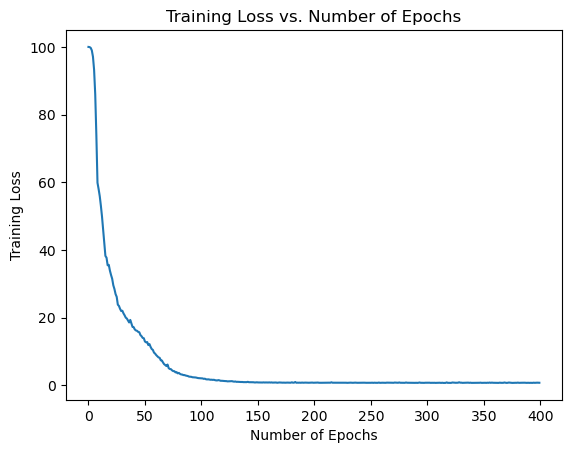

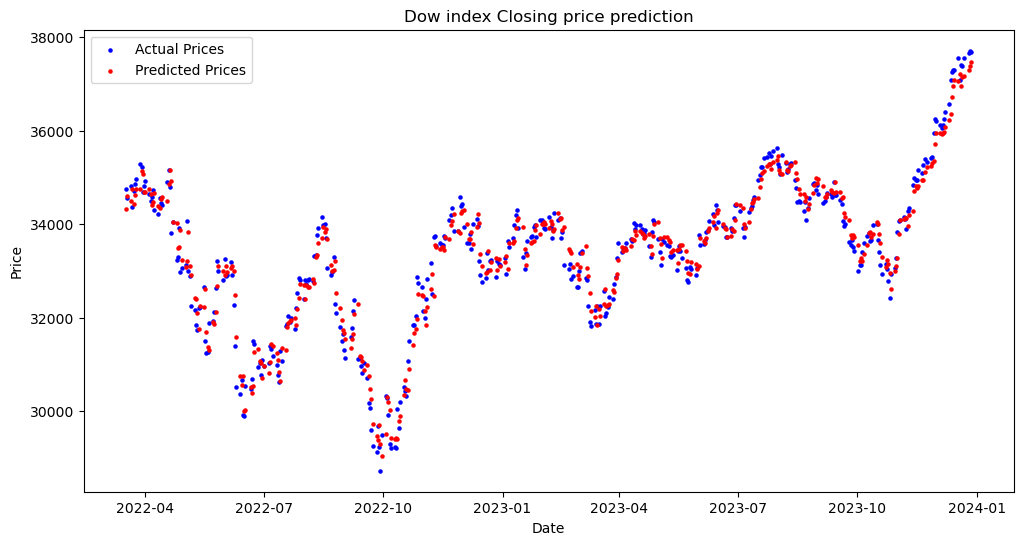

In [20]:
ANN_model_testing('Dow',history_dow,model_dow,X_test_dow,y_test_dow)

### S&P500 Index

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2150  
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Model Validation Loss is: 1.11%


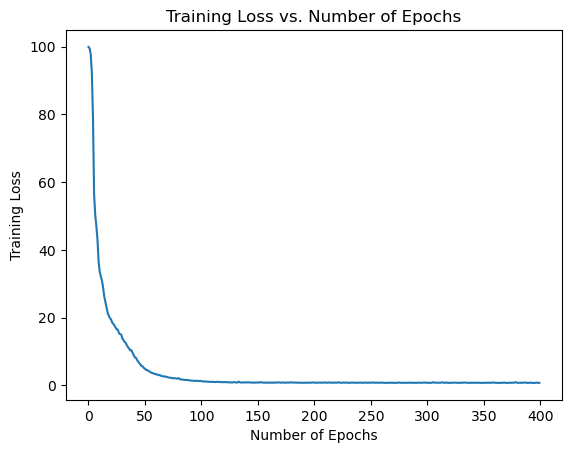

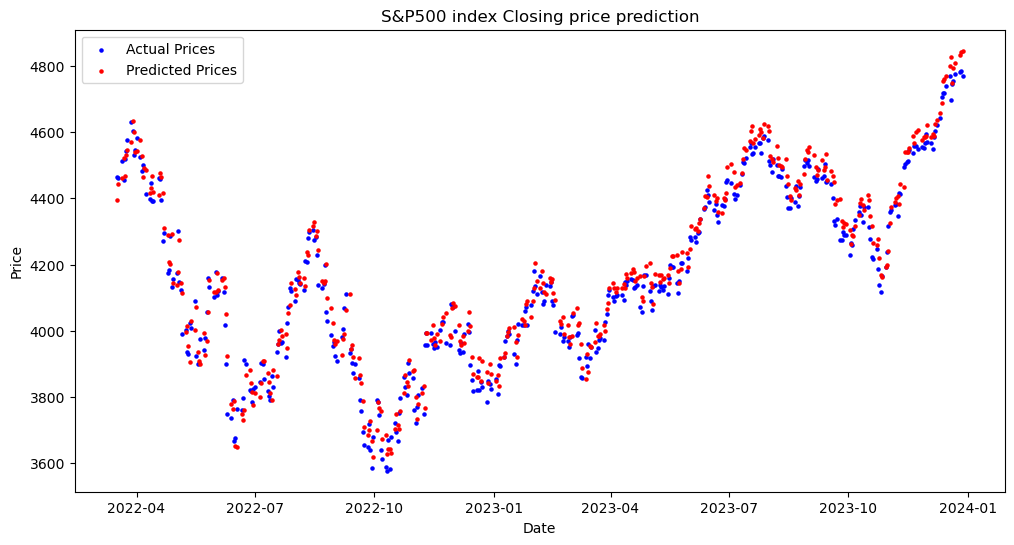

In [21]:
ANN_model_testing('S&P500',history_sp5,model_sp5,X_test_sp5,y_test_sp5)

### Nasdaq 100 Index

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4701  
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Model Validation Loss is: 1.20%


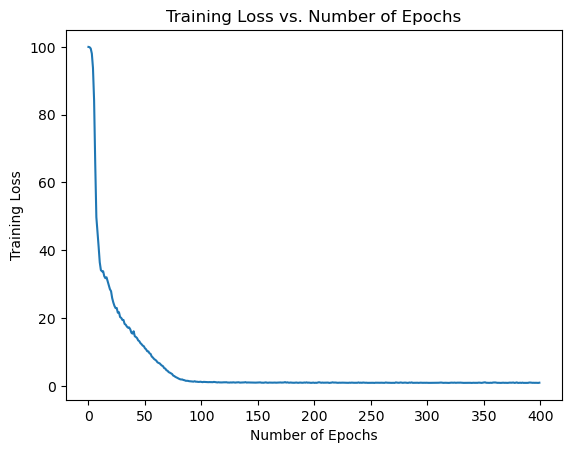

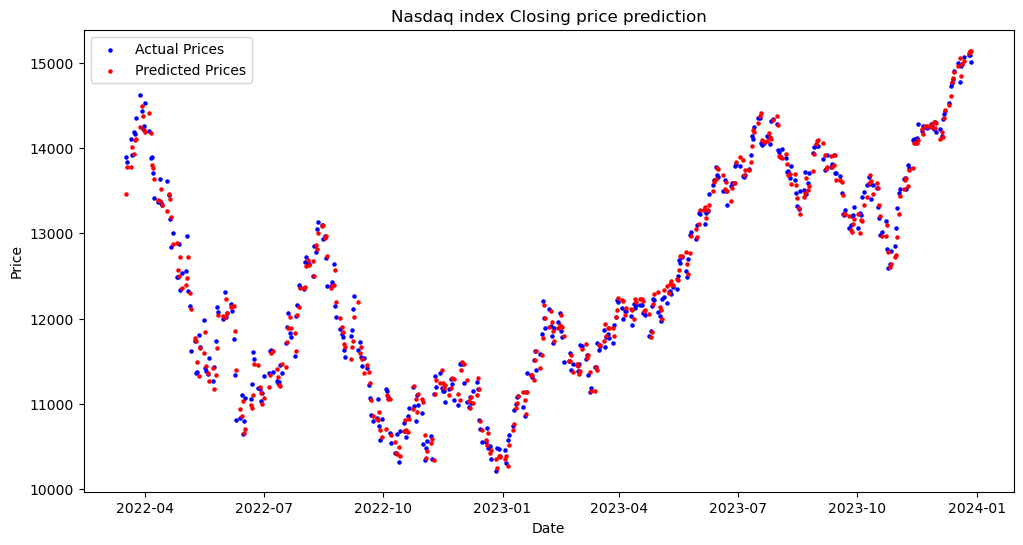

In [22]:
ANN_model_testing('Nasdaq',history_nasd,model_nasd,X_test_nasd,y_test_nasd)

### Result Analysis

**Observations** - We have tried different batch size and epochs. Choosing 400 epochs and 64 batch size work well in our case.  Training loss reduces rapidly in the start and then the model gets converged. Training errors are below 1% for all three models. We have tested these individual models on the testing data for each index. Below results section highlights the testing accuracy.

**Results** - The ANN model is able to successfully forecast the next day closing price of Dow, S&P 500 and Nasdaq index. We get 0.79% error for Dow index. S&P500 index forecast error is around 1% and for Nasdaq the error is 1.25%. Overall, on average 1% forecasting error is observed. Given the non-linearity in timeseries the model performance is superior.

We have also calculated the index volatility above. Results are as follows - 
 - Dow index volatility is: 18.10%
 - S&P500 index volatility is: 18.33%
 - Nasdaq index volatility is: 21.70%

The Nasdaq Composite and the S&P 500 cover more sectors and more stocks in their portfolio, while the Dow is a blue-chip index for 30 stocks. We could see that Nasdaq is slightly higher volatile compared to other two indicies. Given the volatility, model performance is very good for all three indices.

Below table shows the overall model summary and total numbers of parameters.

In [23]:
model_dow.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,717 (45.77 KB)

 Trainable params: 3,905 (15.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,812 (30.52 KB)

 ### Use of Genetic Algorithm to optimise ANN weights

In [134]:
def GANN_model(df):
    
    X = df.drop(['Adj Close','Index','Targetprice'], axis=1)
    y = df['Targetprice']
    #X = dow[['Open', 'High', 'Low', 'Volume','Close','MP','TP', 'SMA_5', 'SMA_10', 'EMA_5', 'RSI', 'UpperBand', 'LowerBand',
    #       'ROC', 'WR', 'ATR', 'ADI', 'MFI', 'CCI']]

    # Standard scaling the input features
    #scaler = StandardScaler()
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    #X_scaled = X
    # Train-Test split
    #X_scaled = X.to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)
    
    return X_train, X_test, y_train, y_test 

In [135]:
X_train_dow, X_test_dow, y_train_dow, y_test_dow  = GANN_model(dow)

Generation = 1
Fitness    = 1.0000001912262015
Change     = 1.0000001912262015
Generation = 2
Fitness    = 1.000007787504181
Change     = 7.596277979526889e-06
Generation = 3
Fitness    = 1.0000266718906232
Change     = 1.8884386442152845e-05
Generation = 4
Fitness    = 1.000057047551361
Change     = 3.0375660737824717e-05
Generation = 5
Fitness    = 1.0001081581903677
Change     = 5.111063900664625e-05
Generation = 6
Fitness    = 1.0002512537890933
Change     = 0.00014309559872560662
Generation = 7
Fitness    = 1.0003231070046437
Change     = 7.185321555036595e-05
Generation = 8
Fitness    = 1.0004238661853937
Change     = 0.00010075918075003187
Generation = 9
Fitness    = 1.000594259928203
Change     = 0.00017039374280924946
Generation = 10
Fitness    = 1.0008635725343553
Change     = 0.00026931260615237207
Generation = 11
Fitness    = 1.0012073716961003
Change     = 0.00034379916174498426
Generation = 12
Fitness    = 1.0013144692747793
Change     = 0.00010709757867899405
Generation 

Generation = 102
Fitness    = 2.999973428262238
Change     = 0.15029863013091171
Generation = 103
Fitness    = 3.2718553325659667
Change     = 0.2718819043037288
Generation = 104
Fitness    = 3.459435110203159
Change     = 0.18757977763719236
Generation = 105
Fitness    = 3.6322718644242973
Change     = 0.1728367542211382
Generation = 106
Fitness    = 4.233071165142362
Change     = 0.6007993007180645
Generation = 107
Fitness    = 4.548691937893487
Change     = 0.3156207727511253
Generation = 108
Fitness    = 4.983102761365184
Change     = 0.4344108234716968
Generation = 109
Fitness    = 5.346688146921189
Change     = 0.3635853855560054
Generation = 110
Fitness    = 5.910869296164663
Change     = 0.5641811492434741
Generation = 111
Fitness    = 6.437609490770513
Change     = 0.5267401946058499
Generation = 112
Fitness    = 7.469651145592809
Change     = 1.0320416548222955
Generation = 113
Fitness    = 8.892000704427945
Change     = 1.422349558835136
Generation = 114
Fitness    = 8.98257

Generation = 204
Fitness    = 19.92927943493102
Change     = 0.040545004107155336
Generation = 205
Fitness    = 19.986809486892604
Change     = 0.057530051961585116
Generation = 206
Fitness    = 20.08928902002112
Change     = 0.10247953312851621
Generation = 207
Fitness    = 20.129704512116344
Change     = 0.04041549209522444
Generation = 208
Fitness    = 20.1607520088748
Change     = 0.031047496758453974
Generation = 209
Fitness    = 20.275015011029982
Change     = 0.11426300215518381
Generation = 210
Fitness    = 20.308251571796934
Change     = 0.033236560766951584
Generation = 211
Fitness    = 20.31016481668693
Change     = 0.0019132448899981114
Generation = 212
Fitness    = 20.413096182254144
Change     = 0.10293136556721194
Generation = 213
Fitness    = 20.46367802107027
Change     = 0.05058183881612521
Generation = 214
Fitness    = 20.537842702471554
Change     = 0.07416468140128529
Generation = 215
Fitness    = 20.540689041182798
Change     = 0.0028463387112438454
Generation = 2

Generation = 307
Fitness    = 24.145011924884486
Change     = 0.003783457958615344
Generation = 308
Fitness    = 24.174456578224426
Change     = 0.029444653339940174
Generation = 309
Fitness    = 24.201312780935858
Change     = 0.026856202711432076
Generation = 310
Fitness    = 24.250475605075145
Change     = 0.04916282413928741
Generation = 311
Fitness    = 24.308920053064476
Change     = 0.05844444798933068
Generation = 312
Fitness    = 24.31892696968042
Change     = 0.010006916615942885
Generation = 313
Fitness    = 24.397296275788403
Change     = 0.07836930610798376
Generation = 314
Fitness    = 24.397296275788403
Change     = 0.0
Generation = 315
Fitness    = 24.430755533690157
Change     = 0.03345925790175386
Generation = 316
Fitness    = 24.430755533690157
Change     = 0.0
Generation = 317
Fitness    = 24.437634400542354
Change     = 0.006878866852197518
Generation = 318
Fitness    = 24.437634400542354
Change     = 0.0
Generation = 319
Fitness    = 24.437634400542354
Change     

Generation = 417
Fitness    = 25.364692087784004
Change     = 0.0
Generation = 418
Fitness    = 25.364692087784004
Change     = 0.0
Generation = 419
Fitness    = 25.36995412836592
Change     = 0.0052620405819148175
Generation = 420
Fitness    = 25.36995412836592
Change     = 0.0
Generation = 421
Fitness    = 25.36995412836592
Change     = 0.0
Generation = 422
Fitness    = 25.36995412836592
Change     = 0.0
Generation = 423
Fitness    = 25.383475624500075
Change     = 0.013521496134156763
Generation = 424
Fitness    = 25.383475624500075
Change     = 0.0
Generation = 425
Fitness    = 25.383475624500075
Change     = 0.0
Generation = 426
Fitness    = 25.396120799716257
Change     = 0.012645175216182025
Generation = 427
Fitness    = 25.396120799716257
Change     = 0.0
Generation = 428
Fitness    = 25.396120799716257
Change     = 0.0
Generation = 429
Fitness    = 25.396120799716257
Change     = 0.0
Generation = 430
Fitness    = 25.396120799716257
Change     = 0.0
Generation = 431
Fitness    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Generation = 500
Fitness    = 25.53153146003021
Change     = 0.0


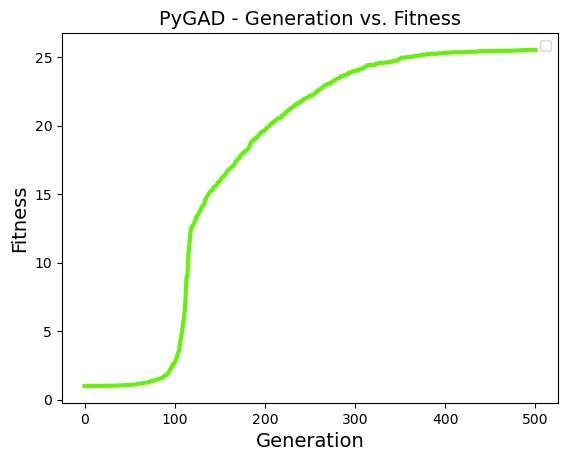

Parameters of the best solution : [ 2.83833893e+00  1.83109576e+00 -3.67668126e+00  4.05036514e+00
  1.23386871e+00  8.27909383e-01  2.63237755e+00  2.68973785e+00
  1.21075812e+00  7.73294980e-01 -3.56994143e+00 -2.53769013e+00
  1.33452675e+00 -5.22036552e-02  1.17331137e+00  3.92657335e+00
  2.55378917e+00 -8.20573931e-01  2.14450175e+00  2.25926914e+00
  4.84498219e+00  9.90339410e+00  7.77851601e-01  1.19060005e+01
  3.35703474e-01  1.41245504e+01  8.35864801e+00  9.25070771e+00
  1.99111663e+00  3.64853849e-02  3.00923010e+00  6.89100363e+00
  2.48743710e+00  1.40820149e+01 -7.80231752e-01  7.06684674e+00
  1.05395497e+01  5.23426345e+00  1.11564829e+00  2.12942859e-01
  1.52071273e+00  9.41576752e-01 -9.25740989e-01  9.01911395e-01
 -2.69311902e+00 -1.23838554e+00 -4.85115415e+00 -3.03086891e+00
  1.66359586e+00 -1.70657578e+00  6.22690138e+00  2.83515692e+00
 -1.19137604e+00  5.09785208e+00 -2.15915241e+00  3.70967410e+00
  7.77515981e+00 -7.24349281e-01 -1.27717307e+00  2.7767

In [138]:
def fitness_func(ga_instance, solution, sol_idx):
    global GANN_instance, data_inputs, data_outputs

    predictions = pygad.nn.predict(last_layer=GANN_instance.population_networks[sol_idx],
                                   data_inputs=data_inputs, problem_type="regression")
    solution_fitness = 1.00/np.mean(np.abs(predictions - data_outputs)/data_outputs)

    return solution_fitness

def callback_generation(ga_instance):
    global GANN_instance, last_fitness

    population_matrices = pygad.gann.population_as_matrices(population_networks=GANN_instance.population_networks, 
                                                            population_vectors=ga_instance.population)

    GANN_instance.update_population_trained_weights(population_trained_weights=population_matrices)

    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]))
    print("Change     = {change}".format(change=ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1] - last_fitness))

    last_fitness = ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1].copy()

# Holds the fitness value of the previous generation.
last_fitness = 0

# Preparing the np array of the inputs.
data_inputs = X_test_dow

# Preparing the np array of the outputs.
data_outputs = np.array(y_test_dow)

# The length of the input vector for each sample (i.e. number of neurons in the input layer).
num_inputs = data_inputs.shape[1]

# Creating an initial population of neural networks.
#The return of the initial_population() function holds references to the networks, not their weights.
#Using such references, the weights of all networks can be fetched.
num_solutions = 40 # A solution or a network can be used interchangeably.
GANN_instance = pygad.gann.GANN(num_solutions=num_solutions,
                                num_neurons_input=num_inputs,
                                num_neurons_hidden_layers=[10,5],
                                num_neurons_output=1,
                                hidden_activations=["relu","relu"],
                                output_activation="None")

# population does not hold the numerical weights of the network instead it holds a list of references to each last layer of each network (i.e. solution) in the population. A solution or a network can be used interchangeably.
# If there is a population with 3 solutions (i.e. networks), then the population is a list with 3 elements. Each element is a reference to the last layer of each network. Using such a reference, all details of the network can be accessed.
population_vectors = pygad.gann.population_as_vectors(population_networks=GANN_instance.population_networks)

# To prepare the initial population, there are 2 ways:
# 1) Prepare it yourself and pass it to the initial_population parameter. This way is useful when the user wants to start the genetic algorithm with a custom initial population.
# 2) Assign valid integer values to the sol_per_pop and num_genes parameters. If the initial_population parameter exists, then the sol_per_pop and num_genes parameters are useless.
initial_population = population_vectors.copy()

num_parents_mating = 4 # Number of solutions to be selected as parents in the mating pool.

num_generations = 500 # Number of generations.

mutation_percent_genes = 5 # Percentage of genes to mutate. This parameter has no action if the parameter mutation_num_genes exists.

parent_selection_type = "sss" # Type of parent selection.

crossover_type = "single_point" # Type of the crossover operator.

mutation_type = "random" # Type of the mutation operator.

keep_parents = 1 # Number of parents to keep in the next population. -1 means keep all parents and 0 means keep nothing.

init_range_low = -4
init_range_high = 4

ga_instance = pygad.GA(num_generations=num_generations, 
                       num_parents_mating=num_parents_mating, 
                       initial_population=initial_population,
                       fitness_func=fitness_func,
                       mutation_percent_genes=mutation_percent_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       keep_parents=keep_parents,
                       on_generation=callback_generation)

ga_instance.run()

# After the generations complete, some plots are showed that summarize how the outputs/fitness values evolve over generations.
ga_instance.plot_fitness()

# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

if ga_instance.best_solution_generation != -1:
    print("Best fitness value reached after {best_solution_generation} generations.".format(best_solution_generation=ga_instance.best_solution_generation))

# Predicting the outputs of the data using the best solution.
predictions = pygad.nn.predict(last_layer=GANN_instance.population_networks[solution_idx],
                               data_inputs=data_inputs,
                               problem_type="regression")
print("Predictions of the trained network : {predictions}".format(predictions=predictions))

# Calculating some statistics
abs_error = 100*np.mean(np.abs(predictions - data_outputs)/data_outputs)
print("Absolute error : {abs_error}.".format(abs_error=abs_error))

In [27]:
# Relu activation fucntion

def relu(inpt):
    result = inpt
    result[inpt<0] = 0
    return result

def predict_outputs(weights_mat, data_inputs, data_outputs):
    predictions = numpy.zeros(shape=(data_inputs.shape[0]))
    for sample_idx in range(data_inputs.shape[0]):
        r1 = data_inputs[sample_idx, :]
        for curr_weights in weights_mat:
            r1 = numpy.matmul(r1, curr_weights)
            r1 = relu(r1)
        predicted_label = numpy.where(r1 == numpy.max(r1))[0][0]
        predictions[sample_idx] = predicted_label
    correct_predictions = numpy.where(predictions == data_outputs)[0].size
    accuracy = (correct_predictions/data_outputs.size)*100
    return accuracy, predictions
    
def fitness(weights_mat, data_inputs, data_outputs, activation="relu"):
    accuracy = numpy.empty(shape=(weights_mat.shape[0]))
    for sol_idx in range(weights_mat.shape[0]):
        curr_sol_mat = weights_mat[sol_idx, :]
        accuracy[sol_idx], _ = predict_outputs(curr_sol_mat, data_inputs, data_outputs, activation=activation)
    return accuracy


ModuleNotFoundError: No module named 'ga'

In [ ]:
class Gene:
    def __init__(self, feature_count):
        self.index = random.randint(0, feature_count - 1)
        self.lower_bound, self.upper_bound = sorted([random.uniform(GENE_BOUND_MIN, GENE_BOUND_MAX) for _ in range(2)])

    def mutate(self, feature_count):
        self.index = min(max(self.index + random.choice([-1, 1]), 0), feature_count - 1)
        self.lower_bound *= random.uniform(0.95, 1.05)
        self.upper_bound *= random.uniform(0.95, 1.05)

    def evaluate(self, feature_vector):
        return self.lower_bound <= feature_vector[self.index] <= self.upper_bound


class Chromosome:
    def __init__(self, feature_count):
        self.genes = [Gene(feature_count) for _ in range(random.randint(GENES_MIN, GENES_MAX))]

    def mutate(self, feature_count):
        for gene in self.genes:
            if random.random() < GENE_MUTATION_RATE:
                gene.mutate(feature_count)

        if random.random() < CHROMOSOME_MUTATION_ADD_RATE:
            self.genes.append(Gene(feature_count))

        if random.random() < CHROMOSOME_MUTATION_DELETE_RATE and len(self.genes) > GENES_MIN:
            self.genes.pop(random.randint(0, len(self.genes) - 1))

    def evaluate(self, feature_vector):
        return all(gene.evaluate(feature_vector) for gene in self.genes)


def main():
    train_data = pd.read_csv(TRAIN_CSV, header=None)
    test_data = pd.read_csv(TEST_CSV, header=None)

    feature_count = train_data.shape[1] - 1
    population = [Chromosome(feature_count) for _ in range(POPULATION_SIZE)]

    for generation in range(GENERATIONS):
        sample = train_data.sample(frac=SAMPLE_SIZE)
        features = sample.iloc[:, :-1].values
        labels = sample.iloc[:, -1].values

        scores = []
        for chromosome in population:
            tp = tn = fp = fn = 0
            for feature_vector, label in zip(features, labels):
                prediction = chromosome.evaluate(feature_vector)
                if prediction:
                    if label == 1:
                        tp += 1
                    else:
                        fp += 1
                else:
                    if label == 0:
                        tn += 1
                    else:
                        fn += 1

            if tp + fp == 0:
                precision = 0
            else:
                precision = tp / (tp + fp)

            if precision == 0:
                fitness = 0
            else:
                fitness = (tp ** 2) / (tp + fp)

            scores.append((fitness, tp, precision, chromosome))

        scores.sort(reverse=True, key=lambda x: x[0])
        top_chromosome = scores[0]
        print(f"Generation {generation}: TP={top_chromosome[1]}, Precision={top_chromosome[2]}")

        survivors = [x[3] for x in scores[:POPULATION_SIZE // 20]]

        population = survivors.copy()
        while len(population) < POPULATION_SIZE:
            parent_a, parent_b = random.sample(survivors, 2)
            child = Chromosome(feature_count)
            child.genes = []
            for gene in parent_a.genes:
                if random.random() < 0.5:
                    child.genes.append(gene)
            for gene in parent_b.genes:
                if random.random() < 0.5:
                    child.genes.append(gene)
            child.mutate(feature_count)
            population.append(child)

    best_chromosome = top_chromosome[3]
    features = test_data.iloc[:, :-1].values
    labels = test_data.iloc[:, -1].values
    tp = tn = fp = fn = 0
    for feature_vector, label in zip(features, labels):
        prediction = best_chromosome.evaluate(feature_vector)
        if prediction:
            if label == 1:
                tp += 1
            else:
                fp += 1
        else:
            if label == 0:
                tn += 1
            else:
                fn += 1

    print_statistics(tp=tp, fp=fp, tn=tn, fn=fn)


if __name__ == "__main__":
    main()

In [ ]:


    def crossover(self, parents1: Population, parents2: Population) -> Population:
        num_parents, num_params = parents1.shape
        crossover_points = np.random.randint(1, num_params, size=num_parents)
        mask = np.random.random(size=parents1.shape) < self.crossover_rate
        crossover_mask = np.arange(num_params) < crossover_points[:, np.newaxis]
        mask = np.logical_and(mask, crossover_mask)
        child1 = parents1 * np.logical_not(mask) + parents2 * mask
        child2 = parents2 * np.logical_not(mask) + parents1 * mask
        children = np.concatenate((child1, child2), axis=0)
        return children

    def mutate(self, children: Population) -> Population:
        mask_off = np.random.random(size=children.shape) < self.neuron_off_rate
        mask_mutate = np.random.random(size=children.shape) < self.mutation_rate
        children[mask_off] = 0.0
        children[mask_mutate] += np.random.normal(scale=0.1, size=np.sum(mask_mutate))
        return children

    def select_parents(self, population: Population) -> Population:
        scores = self.calculate_scores(population)
        normalized_scores = scores / np.sum(scores)
        parent_indices = np.random.choice(
            range(self.population_size),
            size=(self.population_size // 2, 2),
            replace=True,
            p=normalized_scores
        )
        parents = population[parent_indices]
        return parents

    def calculate_scores(self, population: Population) -> list[float]:
        return [self.fitness_fn(individual) for individual in population]

    def run(self) -> None:
        # Initialize population
        num_params = compute_num_params(self.model)
        population: Population = np.random.uniform(low=-1, high=1, size=(self.population_size, num_params))
        scores: list[float] = []
        # Run for num_generations
        for gen in range(self.num_generations):
            # Select parents
            parents = self.select_parents(population)
            # Vectorized crossover and mutation
            children = self.crossover(parents[:, 0], parents[:, 1])
            children_mutated = self.mutate(children)
            # Update population
            population = children_mutated
            # Preserve the best individual using elitism
            scores = self.calculate_scores(population)
            max_score = np.max(scores)
            # Update the best solution and score
            if max_score > self.best_score:
                self.best_score = max_score
                self.best_solution = population[np.argmax(scores)]
            # Preserve the best solution using elitism
            if self.elitism:
                worst_idx = np.argmin(scores)
                population[worst_idx] = self.best_solution
            # Save fitness score of best solution
            self.fitness_scores.append(self.best_score)
            # Print generation info
            if gen % self.on_generation_interval == 0:
                self.on_generation(gen, scores)
        self.on_generation(self.num_generations - 1, scores)

    def plot_fitness(self) -> None:
        """ Plots the fitness of the best solution over time """
        plt.plot(self.fitness_scores)
        plt.title("GA & PyTorch - Iteration vs. Fitness")
        plt.xlabel("Iteration")
        plt.ylabel("Fitness")
        plt.show()

    def print_summary(self) -> None:
        """ Prints a summary of the best solution """
        print(f"Best solution fitness: {self.best_score}")
        print(f"Best solution: {self.best_solution}")